In [207]:
## Initialization and imports
import pandas as pd 
import numpy as np 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

from matplotlib import pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'

## Set random seed
np.random.seed(seed=14)

In [208]:
## Read in pickle data
ing_freq = pd.read_pickle("../model/user_f_df.p")
ing_freq.sample(3)

,brie,herbs,pimientos de padron,goji berries,radish,date,almond milk,potato dumplings,chicken (corn fed),pork sausage,...,wheat flour,zucchini,millet,organic red quinoa,white quinoa,mizuna lettuce,pumpkin,dried tomatoes,sweet chili sauce,cust_id
2,0.0,0.222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0030N00002LQp1pQAD
34,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0030N00002nQk4NQAS
39,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0030N00002PriTRQAZ


In [209]:
ing_freq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 84
Columns: 685 entries, brie to cust_id
dtypes: float64(684), object(1)
memory usage: 455.5+ KB


In [210]:
## Need to scale the features for clustering (distance metric)
def scale_df(df):
    for col in df.columns:
        if col != 'cust_id':
            df[col] = (df[col] - df[col].mean())/df[col].std()
    return df
        
ing_freq = scale_df(ing_freq)

In [211]:
## Exploring which ingredients are the most and least used
cols = ing_freq.columns
ing_means = ing_freq[cols].var()  ## The variance in frequency would indicate strong preferences on ingredient
top_ings = ing_means.sort_values().index.values[:]  ## Choosing the x ingredients with the most variance

top_ing_f = ing_freq[top_ings]
top_ing_f.head(4)

,peanut flakes,japanese mayonnaise,bull's blood salad,perilla,japanese cress,alfa alfa sprouts,parmesan,groats,chipotle chili pepper,ox cheek,...,rice pudding (extra),orange-curry dressing,red fruit jelly (extra),homemade croutons (flour),vegan pannacotta (coconut milk/ agar agar/ vanilla sugar / forest fruit mix),truffles,cardamom,wild herbs,mustard herb,mushroom extract
0,-0.154314,-0.154314,-0.154314,-0.154314,-0.154314,-0.154314,-0.194633,-0.154314,-0.154314,-0.118468,...,-0.108465,-0.108465,-0.108465,-0.108465,-0.220911,-0.108465,-0.108465,-0.108465,-0.108465,-0.108465
1,-0.154314,-0.154314,-0.154314,-0.154314,-0.154314,-0.154314,8.027893,-0.154314,-0.154314,-0.118468,...,9.111079,-0.108465,9.111079,9.111079,-0.220911,-0.108465,-0.108465,-0.108465,-0.108465,-0.108465
2,-0.154314,-0.154314,-0.154314,-0.154314,-0.154314,-0.154314,-0.194633,-0.154314,-0.154314,-0.118468,...,-0.108465,-0.108465,-0.108465,-0.108465,-0.220911,-0.108465,-0.108465,-0.108465,-0.108465,-0.108465
3,6.404043,6.404043,6.404043,6.404043,6.404043,6.404043,-0.194633,-0.154314,-0.154314,-0.118468,...,-0.108465,-0.108465,-0.108465,-0.108465,-0.220911,-0.108465,-0.108465,-0.108465,-0.108465,-0.108465


#### Kmeans clustering

In [212]:
## Assinging the features to X
X = top_ing_f.values

## Kmeans object with cluster rows are clusters and cols are feature coords
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
kmeans.labels_

array([3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 2, 2, 3, 3, 3, 0,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 2, 3, 3, 3, 1, 3,
       3, 1, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3],
      dtype=int32)

In [213]:
## Print the top words from each topic
def print_top_ingredients(centroid_data, vocab, n_top_words):
    
    ## Getting sorted indexs of feature importance
    sortedX = np.argsort(centroid_data, axis = 1)
    
    ## Printing top words in each 'topic'
    for i, row in enumerate(sortedX[:, -1:-n_top_words-1:-1]):
        print("Topic", i,':', ', '.join([vocab[i] for i in row]))

In [214]:
print_top_ingredients(kmeans.cluster_centers_, top_ings, 7)

Topic 0 : pork loin, norwegian salmon, islandic salmon, bay leaf, star anise, meat juice, ground pork
Topic 1 : cranberry, dijon mustard, spring onions, breadcrumbs, goji berries, quark, black sesame
Topic 2 : chicken thigh, gruyère cheese, bayleaf, sheep cheese, tomato puree, minced meat (beef), tahini
Topic 3 : tomato, sesame oil, sesame, yoghurt (dairy), coriander, rocket, romaine lettuce


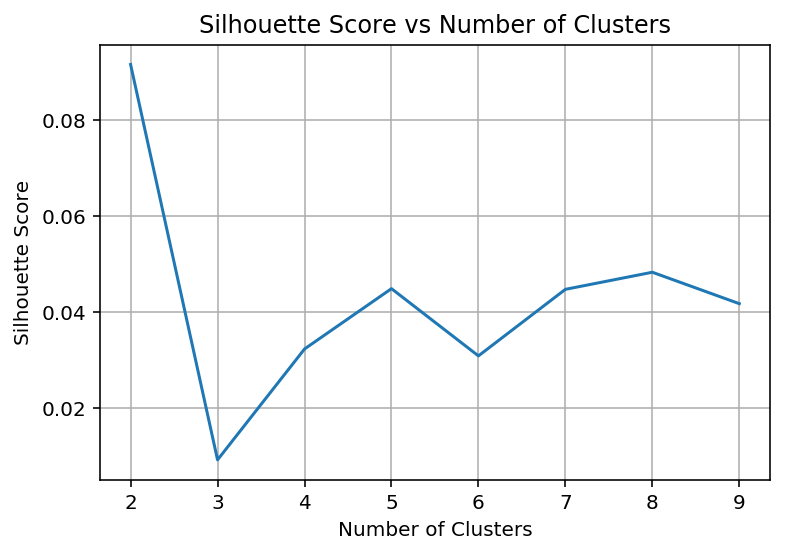

In [215]:
## Scoring Kmeans

## Running kmeans
def run_kmeans(data, n):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
    
    return silhouette_score(data, kmeans.labels_)


## Finds the opitmal k value
def find_k(data, k):
    sil_scores = []
    for i in range(2, k):
        scores = (run_kmeans(data, i))
        sil_scores.append(scores)
        
    return sil_scores 

sils = find_k(X, 10)

plt.title("Silhouette Score vs Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.grid()
plt.plot(range(2, len(sils)+2), sils)

#### Hierarchical Clustering

In [216]:
def high_clustering(data, sample_size, dist_measure='cosine', plot='yes'):

    ## Selecting n random customers to look at
    trimmed_data = np.random.choice(range(data.shape[0]), sample_size)
    X = data.iloc[trimmed_data]

    ## Get vector distances (can be different measures) and squaring array
    Y = pdist(X, 'cosine')
    squareY = squareform(Y)

    ## Creates the linkage matrix with 
    return linkage(squareY, 'average')

## Plot the dendrogram
def plot_dendro(Z, orient='top', thresh=None, font_s=20):
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(Z)

    section = np.array(dn["ivl"]).astype(int)

    dn = dendrogram(Z, 
                    orientation=orient,
                    color_threshold=thresh,
                    leaf_font_size=font_s)
    plt.ylabel('Threshold')
    plt.xlabel('User')
    plt.title('User Ingredient Frequency Dendrogram')
    plt.show()

/Users/nschumacher/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


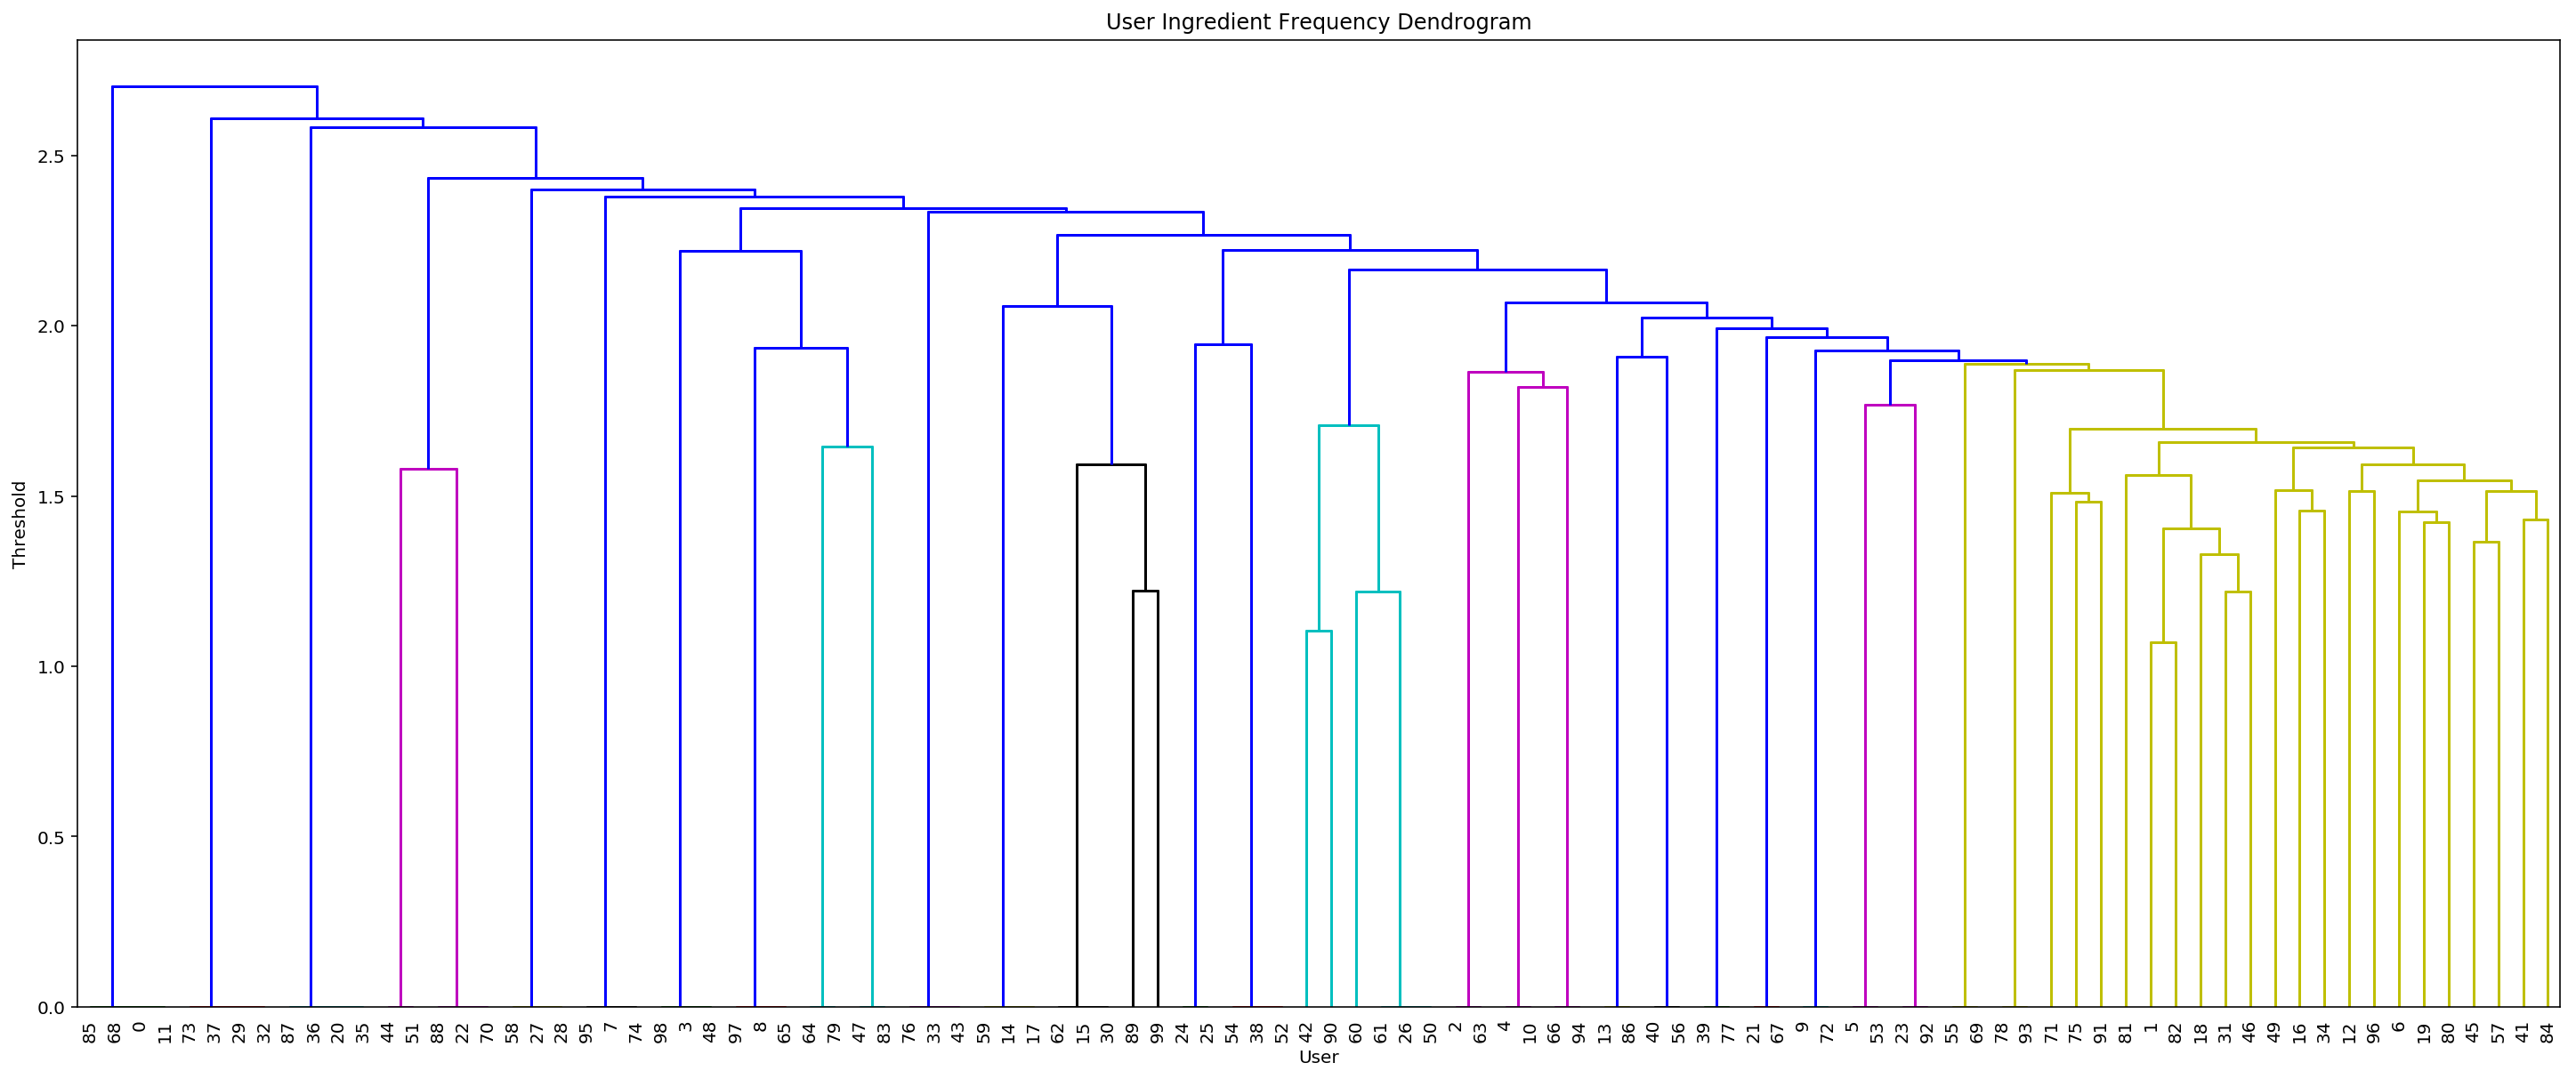

In [217]:
linkage1 = high_clustering(top_ing_f, 100, dist_measure='city_block')
plot_dendro(linkage1, orient='top', font_s=10)